In [0]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
import pylab

from google.colab import drive

# Вопросы по теоретической части урока 2:
# 1. В чём различие между зависимыми и независимыми выборками?

зависимые выборки:
- для каждого объекта в выборках $X_1$ и $X_2$ можно установить гомофорную пару : одному объекту из выборки $X_1$ можно привести в соответствие один и только один объект из выборки $X_2$
- имеют одинаковую размерность

для незавимых выборок первое улсовие не выполняется

# 2. Когда применяются параметрические статистические критерии, а когда их непараметрические аналоги?

## параметрические критерии

в общем случае параметрические стат критерии применяются для проверки гипотез, для которых определено предположение о значении параметра распределений, из которых предположительно взята выборка, например, для следующей задачи:

### для зависимых выборок

существует два варианта рекламных баннеров, относительно которых необходимо определить есть предпочтения пользователей (1 - клик, 0 - отсутствие) в пользу одного из них. расчет статистик производится именно для разности долей

In [5]:
!wget https://raw.githubusercontent.com/maxis42/ML-DA-Coursera-Yandex-MIPT/master/4%20Stats%20for%20data%20analysis/Lectures%20notebooks/8%20two%20proportions%20diff%20test/banner_click_stat.txt

--2019-11-18 08:58:54--  https://raw.githubusercontent.com/maxis42/ML-DA-Coursera-Yandex-MIPT/master/4%20Stats%20for%20data%20analysis/Lectures%20notebooks/8%20two%20proportions%20diff%20test/banner_click_stat.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4000 (3.9K) [text/plain]
Saving to: ‘banner_click_stat.txt’

banner_click_stat.t 100%[===================>]   3.91K  --.-KB/s    in 0s      

2019-11-18 08:58:59 (75.8 MB/s) - ‘banner_click_stat.txt’ saved [4000/4000]



In [16]:
data = pd.read_csv('banner_click_stat.txt', header = None, sep = '\t')
data.columns = ['banner_a', 'banner_b']

print(data.T.apply(lambda x: x.value_counts(), axis=1))

            0   1
banner_a  963  37
banner_b  947  53


In [27]:
# строю доверительные интервалы (уровень значимости оставлю по умолчанию 5%)

conf_banner_a = proportion_confint(sum(data.banner_a), 
                                            data.shape[0],
                                            method = 'wilson')
conf_banner_b = proportion_confint(sum(data.banner_b), 
                                            data.shape[0],
                                            method = 'wilson')

print(f'95% дов интервал для а: {conf_banner_a}')
print(f'95% дов интервал для b: {conf_banner_b}')

95% дов интервал для а: (0.026961180875554734, 0.05058239748206931)
95% дов интервал для b: (0.04074650524859452, 0.06867461683749176)


In [40]:
# интервалы пересекаются => предпочтения однозначно не определить
# выбираю критерий - z 

# функция расчета дов интервала для разности долей (независимая выборки)
def diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

# функция расчета z статистики
def diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

# функция расчета p значения (независимая выборки)
def diff_p_value_ind(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

# ставлю H_0 ： доли одинаковые, пользователям без разницы
print(f'95% дов интервал для разности долей: {diff_confint_ind(data.banner_a, data.banner_b)}')
print(f'z stat: {diff_z_stat_ind(data.banner_a, data.banner_b)}') 
print(f'p value: {diff_p_value_ind(diff_z_stat_ind(data.banner_a, data.banner_b))}')

95% дов интервал для разности долей: (-0.0341571385110543, 0.002157138511054299)
z stat: -1.7258261378415294
p value: 0.08437869601106662


p_value больше уровня значимости => не могу отвергнуть нулевую гипотезу о том, что пользователям без разницы

### зависмая выборка 

пользователи, которые сравнивали баннеры, - один и те же люди

In [44]:
# функция расчета дов интервала для разности долей (зависимая выборки)
def proportions_diff_confint_rel(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    sample = list(zip(sample1, sample2))
    n = len(sample)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

# функция расчета z значения (связаные выборки)
def proportions_diff_z_stat_rel(sample1, sample2):
    sample = list(zip(sample1, sample2))
    n = len(sample)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

# ставлю H_0 ： доли одинаковые, пользователям без разницы
print(f'95% дов интервал для разности долей: {proportions_diff_confint_rel(data.banner_a, data.banner_b)}')
print(f'z stat: {diff_z_stat_ind(data.banner_a, data.banner_b)}') 
print(f'p value: {diff_p_value_ind(proportions_diff_z_stat_rel(data.banner_a, data.banner_b))}')

95% дов интервал для разности долей: (-0.02668926335921826, -0.00531073664078174)
z stat: -1.7258261378415294
p value: 0.0033491428465450834


In [51]:
# p < alpha => у пользователей есть предпочтения
# ставлю H_0 ：предпочтение в сторону баннера b := односторонняя альтернатива

print(f"p value: {diff_p_value_ind(proportions_diff_z_stat_rel(data.banner_a, data.banner_b), alternative='less')}")

p value: 0.0016745714232725471


p < $\alpha$ - отергнуть нулевую не получается => предпочтение в пользу，баннера b

## непараметрические критерии

непараметрические стат критерии применяются для задач след типа: пусть дана выборка объема n из какого то распределения F(x):
$$ X^n = (X_1, ..., X_n), X \sim F(x) $$
необходимо проверить гипотезу о равенстве нулю среднего значения случайной величины, из которой взята эта выборка

для примера возьмем задачу проверить гипотезу о том, изменилась ли цена для недвижимости за 2 периода времени для одной локации

In [54]:
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
data = pd.read_csv('drive/My Drive/geek_data/_2/seattle.txt', sep = '\t', header = 0)

In [62]:
price2001 = data[data['Year']  == 2001].Price
price2002 = data[data['Year']  == 2002].Price
print(price2001.shape, price2002.shape)

(50,) (50,)


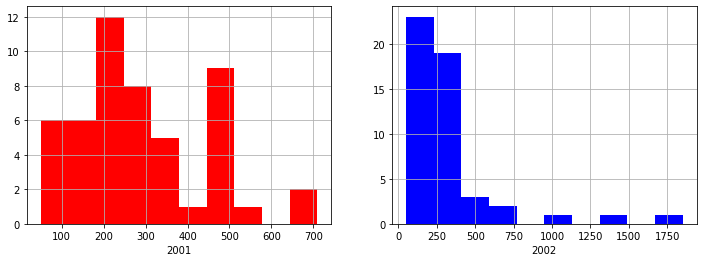

In [64]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(price2001, color = 'r')
pylab.xlabel('2001')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(price2002, color = 'b')
pylab.xlabel('2002')

pylab.show()

# ставим H_0: медиана стоимости для двух периодов совпадает

In [66]:
print(f'95% дов интервал для разности долей для 2001: {zconfint(price2001)}')
print(f'95% дов интервал для разности долей для 2002: {zconfint(price2002)}')

95% дов интервал для разности долей для 2001: (245.19358064978286, 332.65949935021723)
95% дов интервал для разности долей для 2002: (241.4379457326015, 417.07633426739847)


In [68]:
# дов интервалы совпадают

# применяем критерий манна уитни, ранговый, двухвыборочный для незавимых выборок

print(stats.mannwhitneyu(price2001, price2002))

MannwhitneyuResult(statistic=1204.5, pvalue=0.3781936337850874)


In [77]:
# отвергнуть нулевую не можем

# применяем перестановочный критерий 
# H_0 : функции распределения совпадают для выборок двух периодов

# функции расчета t статистики
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

# функция построения всех возможных разбиений выборки на подвыборки
# с ограничением кол-ва возможных комбинаций 
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

# функция построения нулевого распределения
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

# функция p value для рангового критерия
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

print("p-value: %f" % permutation_test(price2001, price2002, max_permutations = 10000))

# print(f'p-value: {permutation_test(price2001, price2002, max_permutations = 20000)}')

p-value: 0.446500


p_value больше уровня значимости => нулевую гипотезу отвергнуть не могу, не могу сделать вывод об изменениях цены для периодов